In [1]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [2]:
%%time
# https://github.com/alexeygrigorev/clothing-dataset
zipf = zipfile.ZipFile('clothing_dataset.zip')

CPU times: user 106 ms, sys: 5.1 ms, total: 111 ms
Wall time: 112 ms


In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
df['image'] = df.filename.apply(lambda x: x.split('.')[0])
print(len(df))
df.sample(n=5)

11524


,index,root_path,filename,path,image
6646,6647,images_original,261b36f3-5c90-4d89-93d2-0d20a7782287.jpg,images_original/261b36f3-5c90-4d89-93d2-0d20a7...,261b36f3-5c90-4d89-93d2-0d20a7782287
6725,6726,images_original,291e4ba7-108a-49c1-9ca9-b6d37fc28aa7.jpg,images_original/291e4ba7-108a-49c1-9ca9-b6d37f...,291e4ba7-108a-49c1-9ca9-b6d37fc28aa7
4185,4186,images_compressed,bd16eb2b-2233-4c09-a3e4-04d9f8bf0441.jpg,images_compressed/bd16eb2b-2233-4c09-a3e4-04d9...,bd16eb2b-2233-4c09-a3e4-04d9f8bf0441
1372,1373,images_compressed,3b384197-7b19-464b-8bd7-823d4128ce74.jpg,images_compressed/3b384197-7b19-464b-8bd7-823d...,3b384197-7b19-464b-8bd7-823d4128ce74
3960,3961,images_compressed,b280d5e4-89ff-4025-ad7e-beff5f6813e9.jpg,images_compressed/b280d5e4-89ff-4025-ad7e-beff...,b280d5e4-89ff-4025-ad7e-beff5f6813e9


### Load category data

In [5]:
df_meta = pd.read_csv('clothing-dataset.csv')
df = pd.merge(df, df_meta, on='image')

# Basic EDA


In [6]:
print(np.unique(df.label.values))
len(np.unique(df.label.values))

['Blazer' 'Blouse' 'Body' 'Dress' 'Hat' 'Hoodie' 'Longsleeve' 'Not sure'
 'Other' 'Outwear' 'Pants' 'Polo' 'Shirt' 'Shoes' 'Shorts' 'Skip' 'Skirt'
 'T-Shirt' 'Top' 'Undershirt']


20

In [7]:
df.groupby('label').count().sort_values('image', ascending=False)[:15]

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
T-Shirt,2022,2022,2022,2022,2022,2022,2022
Longsleeve,1398,1398,1398,1398,1398,1398,1398
Pants,1384,1384,1384,1384,1384,1384,1384
Shoes,862,862,862,862,862,862,862
Shirt,756,756,756,756,756,756,756
Dress,714,714,714,714,714,714,714
Outwear,624,624,624,624,624,624,624
Shorts,616,616,616,616,616,616,616
Not sure,456,456,456,456,456,456,456


### Inspect a few sample images and corresponding bounding boxes (BBOX is 100% for these)

In [8]:
df = df[df.root_path=='images_original']
len(df)

5403

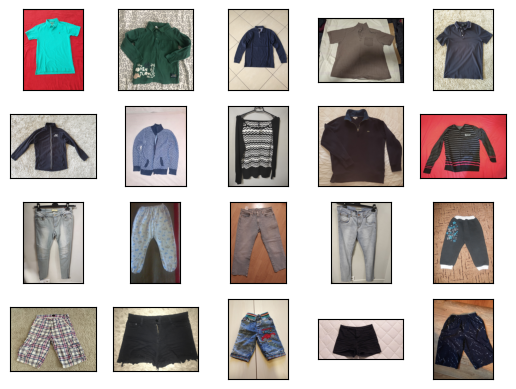

In [10]:
cats = ['Polo', 'Longsleeve', 'Pants', 'Shorts']
fig, ax = plt.subplots(len(cats),5)
i=0
for cat in cats:
    toplot = df[df.label==cat].sample(5)
    j=0
    for idx, row in toplot.iterrows():
        img = Image.open(io.BytesIO(zipf.read(row.path)))
        img.thumbnail((640,640))
        ax[i,j].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax[i,j].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

        ax[i,j].imshow(img)
        j+=1
    i+=1
    

plt.show()

# Define Bounding Boxes

In [14]:
def findBoundingBox(img, inclBoxImg=False):
    img_bbox = None
    # inspired by:  https://automaticaddison.com/how-to-detect-and-draw-contours-in-images-using-opencv/
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find contours within the image
    ret, binary = cv2.threshold(gray, 100, 255, 
      cv2.THRESH_OTSU)
    inverted_binary = ~binary
    contours, hierarchy = cv2.findContours(inverted_binary,
      cv2.RETR_TREE,
      cv2.CHAIN_APPROX_SIMPLE)

    # find largest object
    max_size = 0
    max_idx = 0
    for i in range(len(contours)):
        if max_size < len(contours[i]):
            max_size = len(contours[i])
            max_idx = i

    # determine bounding box
    x, y, w, h = cv2.boundingRect(contours[max_idx])
    
    #print(img.shape, x, y, w, h)
    if ((w<img.shape[1]*.75) & (h<img.shape[0]*.75)) | \
       ((x>img.shape[1]*.33) | (y>img.shape[0]*.33)):   # is the box too small?
        w = img.shape[1]
        h = img.shape[0]
        x = 0
        y = 0
    #print(img.shape, x, y, w, h, '\n')

    # markup the image with the bbox
    # for debugging
    if inclBoxImg:
        img_bbox = cv2.rectangle(img,(x,y), (x+w,y+h), (255,0,0), 20)
    
    return x, y, w, h, img_bbox

In [12]:
toplot = []
for cat in cats:
    toplot.append(df[df.label==cat].sample(5))

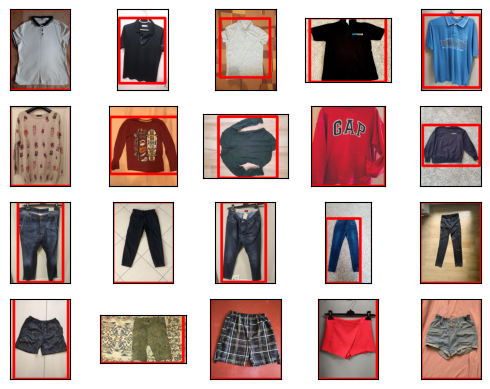

In [17]:
fig, ax = plt.subplots(len(cats),5)
i=0
for torow in toplot[:]:
    j=0
    for idx, row in torow.iterrows():
        img = Image.open(io.BytesIO(zipf.read(row.path)))
        img.thumbnail((640,640))
        x, y, w, h, img = findBoundingBox(img, inclBoxImg=True)
        ax[i,j].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax[i,j].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

        ax[i,j].imshow(img)
        j+=1
    i+=1
    
plt.show()

# Merge & Filter Categories

By inspecting a few samples images I noticed that:

- Shorts and skirts are visually very similar
- Shirts contains both short and long-sleeve
- Short-sleeve can include T's and Polos

Actions:
- Merge shorts and skirts
- Include all polos and sample of T-shirts
- Keep Pants and Longsleeve

In [18]:
df_mod = df.copy()

In [19]:
df_mod.loc[df_mod.label=='Shorts','label'] = 'shorts'
df_mod.loc[df_mod.label=='Skirt','label'] = 'shorts'
df_mod.loc[df_mod.label=='Longsleeve','label'] = 'long sleeve top'
df_mod.loc[df_mod.label=='Pants','label'] = 'trousers'
df_mod.loc[df_mod.label=='Polo','label'] = 'short sleeve top'

In [20]:
sample_idx = df_mod[df_mod.label=='T-Shirt'].sample(500).image
df_mod.loc[df_mod.image.isin(sample_idx),'label'] = 'short sleeve top'

In [21]:
df_mod.groupby('label').count().sort_values('image', ascending=False)[:6]

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
long sleeve top,699,699,699,699,699,699,699
trousers,692,692,692,692,692,692,692
short sleeve top,620,620,620,620,620,620,620
T-Shirt,511,511,511,511,511,511,511
shorts,463,463,463,463,463,463,463
Shoes,431,431,431,431,431,431,431


In [22]:
# to be comparable with the test on 16k DF1
cats = ['long sleeve top', 
        'short sleeve top', 
        'shorts', 
        'trousers']

In [23]:
samples = df_mod[df_mod.label.isin(cats)]
samples.groupby('label').count().sort_values('image', ascending=False)

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
long sleeve top,699,699,699,699,699,699,699
trousers,692,692,692,692,692,692,692
short sleeve top,620,620,620,620,620,620,620
shorts,463,463,463,463,463,463,463


# Prepare train/val split

In [24]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(samples, test_size=0.2)
print(len(train),len(val))

1979 495


In [25]:
# is it still balanced?
train.groupby('label').count().sort_values('image', ascending=False)

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
trousers,562,562,562,562,562,562,562
long sleeve top,558,558,558,558,558,558,558
short sleeve top,487,487,487,487,487,487,487
shorts,372,372,372,372,372,372,372


# Prepare dataset for YOLO

In [26]:
train.iloc[0]

index                                                    10557
root_path                                      images_original
filename              d619091d-fc8d-4730-9f3c-2a042e876272.jpg
path         images_original/d619091d-fc8d-4730-9f3c-2a042e...
image                     d619091d-fc8d-4730-9f3c-2a042e876272
sender_id                                                  312
label                                                   shorts
kids                                                     False
Name: 9003, dtype: object

In [61]:
if not os.path.exists('clothdata'):
    os.mkdir('clothdata')

if not os.path.exists('clothdata/images'):
    os.mkdir('clothdata/images')
if not os.path.exists('clothdata/images/train'):
    os.mkdir('clothdata/images/train')
if not os.path.exists('clothdata/images/val'):
    os.mkdir('clothdata/images/val')

if not os.path.exists('clothdata/labels'):
    os.mkdir('clothdata/labels')
if not os.path.exists('clothdata/labels/train'):
    os.mkdir('clothdata/labels/train')
if not os.path.exists('clothdata/labels/val'):
    os.mkdir('clothdata/labels/val')

In [64]:
def createFiles(data=train, type_='train'):
    target_dim = 640.0
    for i, row in tqdm(data[:].iterrows()):
        filepath = row.path
        img = Image.open(io.BytesIO(zipf.read(filepath)))        
        img.thumbnail((target_dim, target_dim)) 
        
        if 'png' in str(type(img)).lower():
            img = img.convert('RGB')
        img.save('clothdata/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

        x0, y0, w, h, _ = findBoundingBox(img)

        x = round(float(x0 + w/2.0)/float(img.size[0]), 3)
        y = round(float(y0 + h/2.0)/float(img.size[1]), 3)
        w = round(w/float(img.size[0]), 3)
        h = round(h/float(img.size[1]), 3)

        idx = cats.index(row.label)
        metadata = str(idx) + f' {x} {y} {w} {h}'
        fileroot = 'clothdata/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

        f = open(fileroot, 'w')
        f.write(metadata)
        f.close()

In [65]:
createFiles(train, type_='train')
createFiles(val, type_='val')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
lines = []
lines.append('path: ../datasets/clothdata # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('clothdata/clothdata.yaml', 'w')
f.writelines(lines)
f.close()